# Algorytmy Tekstowe - lab. 6
# Słownik spójnych składowych, algorytm KMR
### Mateusz Kocot
-------------------------------------------------------
## Implementacja słownika spójnych składowych i wyszukiwania wzorca

Funkcja `renumber`, która będzie wywoływana w każdej iteracji algorytmu budowy słownika KMR, wykorzystuje sortowanie kubełkowe (`bucket_sort`) w celu zapewnienia złożoności *O(nlogn)* budowy DBF. Oprócz tego, zaimplementowano wyszukiwanie połówkowe (`binary_search`), które będzie potrzebne przy wyszukiwaniu wzorca.

In [1]:
import math

In [2]:
def bucket_sort(arr, max_number, buckets_number):
    step = (max_number + 1) / buckets_number
    buckets = [None] * (buckets_number + 1)
    for x in arr:
        idx = int(x[0][0] / step)
        if buckets[idx] is not None:
            buckets[idx] += [x]
        else:
            buckets[idx] = [x]
    result = []
    for bucket in buckets:
        if bucket is not None:
            bucket.sort()
            result += bucket
    return result

def renumber(S, use_bucket_sort=True, max_number=None):
    entries = [(tuple(s), i) for i, s in enumerate(S)]
    if use_bucket_sort:
        entries = bucket_sort(entries, max_number, max(1, len(entries) // 16))
    else:
        entries.sort()
    
    pos = [entries[0][1]]
    num = [None] * len(S)
    num[entries[0][1]] = 0
    
    last_idx = 0
    for i in range(1, len(S)):
        if entries[i][0] != entries[i - 1][0]:
            pos += [entries[i][1]]
            last_idx += 1
        num[entries[i][1]] = last_idx
        
    return num, pos

def binary_search(arr, text, pattern):
    return _binary_search(arr, text, pattern, 0, len(arr) - 1)

def _binary_search(arr, text, pattern, low, high):
    if high < low:
        return None
    
    n = len(pattern)
    mid = (high + low) // 2
    text_fragment = text[arr[mid]:arr[mid] + n]
    
    if(text_fragment == pattern):
        return mid
    elif (text_fragment > pattern):
        return _binary_search(arr, text, pattern, low, mid - 1)
    else:
        return _binary_search(arr, text, pattern, mid + 1, high)

Klasa `DBF` przyjmuje w konstruktorze tekst i w oparciu o ten tekst tworzy słownik spójnych składowych (tablice *NUM* i *POS*). Sama budowa obsługiwana jest w metodzie `_kmr`, czyli implementacji algorytmu KMR. Metoda `find_pattern` odpowiedzialna jest za wyszukiwanie wzorca w zbudowanym już słowniku. Wykorzystuje ona wyszukiwanie połówkowe w celu znalezienia odpowiedniego indeksu w tablicy *POS*. W przypadku, gdy długość wzorca nie jest potęgą dwójki, jest on rozbijany na dwa mniejsze wzorce o odpowiednich już długościach. Nie ma potrzeby każdorazowego przerabiania słownika przy wyszukiwaniu nowego wzorca.

In [3]:
class DBF:
    
    def __init__(self, text):
        self.text = text
        self.N = len(text)
        self.NUM, self.POS = self._kmr()
        
    def __str__(self):
        result = 'NUM:\n'
        k = 1
        for num in self.NUM:
            result += str(k) + ' ' + str(num) + '\n'
            k *= 2
            
        result += 'POS:\n'
        k = 1
        for pos in self.POS:
            result += str(k) + ' ' + str(pos) + '\n'
            k *= 2
            
        return result
    
    def find_pattern(self, pattern):
        if len(pattern) > len(self.text):
            return []
        l = int(math.log2(len(pattern)))
        log_len = pow(2, l)
        if len(pattern) == log_len:
            pos_idx = binary_search(self.POS[l], self.text, pattern)
            if pos_idx is None:
                return []
            start_num = self.POS[l][pos_idx]
            result = [start_num]
            
            for i in range(start_num + 1, len(self.NUM[l])):
                num_el = self.NUM[l][i]
                if num_el == pos_idx:
                    result += [i]
                    
            return result
        else:
            pattern_first = pattern[:log_len]
            pattern_second = pattern[len(pattern) - log_len:]
            
            pos_idx_first = binary_search(self.POS[l], self.text, pattern_first)
            if pos_idx_first is None:
                return []
            
            pos_idx_second = binary_search(self.POS[l], self.text, pattern_second)
            if pos_idx_second is None:
                return []
            
            result = []
            p = self.POS[l][pos_idx_first]
            r = self.POS[l][pos_idx_first] + len(pattern) - log_len
            while r < len(self.NUM[l]):
                num_el_first = self.NUM[l][p]
                num_el_second = self.NUM[l][r]
                if num_el_first == pos_idx_first and num_el_second == pos_idx_second:
                    result += [p]
                    
                p += 1
                r += 1
                    
            return result
                
            
        
    def _kmr(self):
        num, pos = renumber(self.text, use_bucket_sort=False)
        NUM = [num]
        POS = [pos]

        p = 2
        prev_p = 1
        while p <= self.N:
            y = [None] * (self.N - p + 1)
            max_number = 1
            for i in range(self.N - p + 1):
                y[i] = (num[i], num[i + prev_p])
                max_number = max(max_number, num[i], num[i + prev_p])
            num, pos = renumber(y, max_number=max_number)
            NUM += [num]
            POS += [pos]

            prev_p = p
            p *= 2

        return NUM, POS

In [4]:
dbf = DBF('abbababba')
print(dbf)
print('abba:', dbf.find_pattern('abba'))
print('abb:', dbf.find_pattern('abb'))

NUM:
1 [0, 1, 1, 0, 1, 0, 1, 1, 0]
2 [0, 2, 1, 0, 1, 0, 2, 1]
4 [1, 4, 2, 0, 3, 1]
8 [0, 1]
POS:
1 [0, 1]
2 [0, 2, 1]
4 [3, 0, 2, 4, 1]
8 [0, 1]

abba: [0, 5]
abb: [0, 5]


## Test złożoności budowania DBF

In [5]:
import time
%matplotlib notebook
from matplotlib import pyplot as plt
import string
import random

In [6]:
def exec_time(fun, *args, count=1):
    start = time.time()
    for i in range(count):
        fun(*args)
    end = time.time()
    return (end - start) / count

In [7]:
alphabet = string.ascii_letters + string.digits

x_data = []
y_data = []
x = 128
while x <= pow(2, 17):
    text = ''.join([random.choice(alphabet) for _ in range(x)])
    x_data += [x]
    count = 1
    if x < 2000:
        count = 10
    elif x < 80000:
        count = 2
    y_data += [exec_time(DBF, text, count=count)]
    x *= 2

<IPython.core.display.Javascript object>


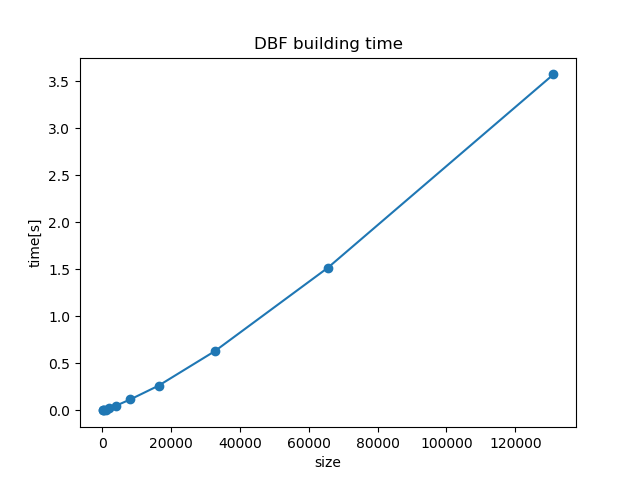

In [8]:
plt.close()
plt.plot(x_data, y_data, marker='o')
plt.title('DBF building time')
plt.xlabel('size')
plt.ylabel('time[s]')

plt.show()

Jak widać, gdy rozmiar problemu rośnie dwukrotnie, czas wykonania rośnie trochę więcej niż dwukrotnie. Zgodnie z oczekiwaniami jest to złożoność *O(nlogn)*.

## Implementacja drzewa sufiksów
Źródło: https://github.com/kvh/Python-Suffix-Tree <br>
Nie wykorzystałem implementacji z lab. 2 ze względu na dużo szybsze działanie implementacji z powyższego źródła.

In [9]:
class Node(object):
    """A node in the suffix tree. 
    
    suffix_node
        the index of a node with a matching suffix, representing a suffix link.
        -1 indicates this node has no suffix link.
    """
    def __init__(self):
        self.suffix_node = -1   

    def __repr__(self):
        return "Node(suffix link: %d)"%self.suffix_node

class Edge(object):
    """An edge in the suffix tree.
    
    first_char_index
        index of start of string part represented by this edge
        
    last_char_index
        index of end of string part represented by this edge
        
    source_node_index
        index of source node of edge
    
    dest_node_index
        index of destination node of edge
    """
    def __init__(self, first_char_index, last_char_index, source_node_index, dest_node_index):
        self.first_char_index = first_char_index
        self.last_char_index = last_char_index
        self.source_node_index = source_node_index
        self.dest_node_index = dest_node_index
        
    @property
    def length(self):
        return self.last_char_index - self.first_char_index

    def __repr__(self):
        return 'Edge(%d, %d, %d, %d)'% (self.source_node_index, self.dest_node_index 
                                        ,self.first_char_index, self.last_char_index )


class Suffix(object):
    """Represents a suffix from first_char_index to last_char_index.
    
    source_node_index
        index of node where this suffix starts
    
    first_char_index
        index of start of suffix in string
        
    last_char_index
        index of end of suffix in string
    """
    def __init__(self, source_node_index, first_char_index, last_char_index):
        self.source_node_index = source_node_index
        self.first_char_index = first_char_index
        self.last_char_index = last_char_index
        
    @property
    def length(self):
        return self.last_char_index - self.first_char_index
                
    def explicit(self):
        """A suffix is explicit if it ends on a node. first_char_index
        is set greater than last_char_index to indicate this.
        """
        return self.first_char_index > self.last_char_index
    
    def implicit(self):
        return self.last_char_index >= self.first_char_index

        
class SuffixTree(object):
    """A suffix tree for string matching. Uses Ukkonen's algorithm
    for construction.
    """
    def __init__(self, string, case_insensitive=False):
        """
        string
            the string for which to construct a suffix tree
        """
        self.string = string
        self.case_insensitive = case_insensitive
        self.N = len(string) - 1
        self.nodes = [Node()]
        self.edges = {}
        self.active = Suffix(0, 0, -1)
        if self.case_insensitive:
            self.string = self.string.lower()
        for i in range(len(string)):
            self._add_prefix(i)
    
    def __repr__(self):
        """ 
        Lists edges in the suffix tree
        """
        curr_index = self.N
        s = "\tStart \tEnd \tSuf \tFirst \tLast \tString\n"
        values = list(self.edges.values())
        values.sort(key=lambda x: x.source_node_index)
        for edge in values:
            if edge.source_node_index == -1:
                continue
            s += "\t%s \t%s \t%s \t%s \t%s \t"%(edge.source_node_index
                    ,edge.dest_node_index 
                    ,self.nodes[edge.dest_node_index].suffix_node 
                    ,edge.first_char_index
                    ,edge.last_char_index)
                    
            
            top = min(curr_index, edge.last_char_index)
            s += self.string[edge.first_char_index:top+1] + "\n"
        return s
            
    def _add_prefix(self, last_char_index):
        """The core construction method.
        """
        last_parent_node = -1
        while True:
            parent_node = self.active.source_node_index
            if self.active.explicit():
                if (self.active.source_node_index, self.string[last_char_index]) in self.edges:
                    # prefix is already in tree
                    break
            else:
                e = self.edges[self.active.source_node_index, self.string[self.active.first_char_index]]
                if self.string[e.first_char_index + self.active.length + 1] == self.string[last_char_index]:
                    # prefix is already in tree
                    break
                parent_node = self._split_edge(e, self.active)
        

            self.nodes.append(Node())
            e = Edge(last_char_index, self.N, parent_node, len(self.nodes) - 1)
            self._insert_edge(e)
            
            if last_parent_node > 0:
                self.nodes[last_parent_node].suffix_node = parent_node
            last_parent_node = parent_node
            
            if self.active.source_node_index == 0:
                self.active.first_char_index += 1
            else:
                self.active.source_node_index = self.nodes[self.active.source_node_index].suffix_node
            self._canonize_suffix(self.active)
        if last_parent_node > 0:
            self.nodes[last_parent_node].suffix_node = parent_node
        self.active.last_char_index += 1
        self._canonize_suffix(self.active)
        
    def _insert_edge(self, edge):
        self.edges[(edge.source_node_index, self.string[edge.first_char_index])] = edge
        
    def _remove_edge(self, edge):
        self.edges.pop((edge.source_node_index, self.string[edge.first_char_index]))
        
    def _split_edge(self, edge, suffix):
        self.nodes.append(Node())
        e = Edge(edge.first_char_index, edge.first_char_index + suffix.length, suffix.source_node_index, len(self.nodes) - 1)
        self._remove_edge(edge)
        self._insert_edge(e)
        self.nodes[e.dest_node_index].suffix_node = suffix.source_node_index  ### need to add node for each edge
        edge.first_char_index += suffix.length + 1
        edge.source_node_index = e.dest_node_index
        self._insert_edge(edge)
        return e.dest_node_index

    def _canonize_suffix(self, suffix):
        """This canonizes the suffix, walking along its suffix string until it 
        is explicit or there are no more matched nodes.
        """
        if not suffix.explicit():
            e = self.edges[suffix.source_node_index, self.string[suffix.first_char_index]]
            if e.length <= suffix.length:
                suffix.first_char_index += e.length + 1
                suffix.source_node_index = e.dest_node_index
                self._canonize_suffix(suffix)
 

    # Public methods
    def find_substring(self, substring):
        """Returns the index of substring in string or -1 if it
        is not found.
        """
        if not substring:
            return -1
        if self.case_insensitive:
            substring = substring.lower()
        curr_node = 0
        i = 0
        while i < len(substring):
            edge = self.edges.get((curr_node, substring[i]))
            if not edge:
                return -1
            ln = min(edge.length + 1, len(substring) - i)
            if substring[i:i + ln] != self.string[edge.first_char_index:edge.first_char_index + ln]:
                return -1
            i += edge.length + 1
            curr_node = edge.dest_node_index
        return edge.first_char_index - len(substring) + ln
        
    def has_substring(self, substring):
        return self.find_substring(substring) != -1

## Porównanie czasów budowy DBF i drzewa sufiksów

In [10]:
file_names = ['1997_714.txt', 'romeo-i-julia-700.txt', 'zad6']

for file_name in file_names:
    with open(file_name, errors='ignore') as file:
        text = file.read()
        
    size = len(text)
    dbf_time = exec_time(DBF, text)
    suffix_tree_time = exec_time(SuffixTree, text)
    
    print('Nazwa pliku:', file_name)
    print('Długość tekstu:', size)
    print('Czas budowy DBF:', dbf_time, 's')
    print('Czas budowy drzewa sufiksów:', suffix_tree_time, 's')
    print('----------------------------')

Nazwa pliku: 1997_714.txt
Długość tekstu: 254125
Czas budowy DBF: 7.5498082637786865 s
Czas budowy drzewa sufiksów: 1.8660094738006592 s
----------------------------
Nazwa pliku: romeo-i-julia-700.txt
Długość tekstu: 13506
Czas budowy DBF: 0.21642088890075684 s
Czas budowy drzewa sufiksów: 0.07280564308166504 s
----------------------------
Nazwa pliku: zad6
Długość tekstu: 947
Czas budowy DBF: 0.008976459503173828 s
Czas budowy drzewa sufiksów: 0.005984067916870117 s
----------------------------


Drzewo sufiksów budowane jest dużo szybciej, niż DBF w mojej implementacji. Pozwala ono jednak tylko na sprawdzenie, czy wzorzec w ogóle występuje w tekście, podczas gdy DBF znajduje wszystkie pozycje.

## Porównanie rozmiaru DBF z wielkością pliku

In [11]:
import sys

In [12]:
def get_dbf_size(dbf):
    result = 0
    for dbf_list in dbf:
        result += sys.getsizeof(dbf_list)
        for row in dbf_list:
            result += sys.getsizeof(row)
            for el in row:
                result += sys.getsizeof(el)
    return result

In [13]:
file_names = ['1997_714.txt', 'romeo-i-julia-700.txt', 'zad6']

for file_name in file_names:
    with open(file_name, errors='ignore') as file:
        text = file.read()
        
    text_size = len(text) * 8
    dbf = DBF(text)
    dbf_size = get_dbf_size((dbf.NUM, dbf.POS))
    
    print('Nazwa pliku:', file_name)
    print('Rozmiar tekstu:', text_size, 'bitów')
    print('Rozmiar DBF:', dbf_size, 'bitów')
    print('----------------------------')

Nazwa pliku: 1997_714.txt
Rozmiar tekstu: 2033000 bitów
Rozmiar DBF: 272342660 bitów
----------------------------
Nazwa pliku: romeo-i-julia-700.txt
Rozmiar tekstu: 108048 bitów
Rozmiar DBF: 11240944 bitów
----------------------------
Nazwa pliku: zad6
Rozmiar tekstu: 7576 bitów
Rozmiar DBF: 549016 bitów
----------------------------


Wadą DBF jest duży rozmiar przechowywanych tablic.

## Implementacja KMP
Moja implementacja z lab. 1.

In [14]:
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while (k > 0 and pattern[k] != pattern[q]):
            k = pi[k - 1]
        if(pattern[k] == pattern[q]):
            k = k + 1
        pi.append(k)
    return pi

def kmp_string_matching(text_source, pattern):
    pi = prefix_function(pattern)
    result = []
    q = 0
    with open(text_source, 'r', errors='ignore') as file:
        text = file.read()
        for i in range(0, len(text)):
            while (q > 0 and pattern[q] != text[i]):
                q = pi[q - 1]
            if (pattern[q] == text[i]):
                q = q + 1
            if (q == len(pattern)):
                result.append(i + 1 - q)
                q = pi[q - 1]
    return result

## Porównanie czasów wykonania wzorca przy użyciu DBF i KMP

In [15]:
import string

In [16]:
patterns = ['a', 'gdzi', 'gdzie', 'Szatana, wszystkich Montekich i ', 'Szatana, wszystkich Montekich i ciebie.']

file_name = 'romeo-i-julia-700.txt'
with open(file_name, errors='ignore') as file:
    text = file.read()
    
dbf = DBF(text)
print('Tekst:', file_name)
print('============================')

for pattern in patterns:
    pattern_size = len(pattern)
    
    dbf_time = exec_time(dbf.find_pattern, pattern, count=100)
    kmp_time = exec_time(kmp_string_matching, file_name, pattern, count=100)
    
    print('Rozmiar wzorca:', pattern_size)
    print('Czas wyszukiwania DBF:', dbf_time, 's')
    print('Czas wyszukiwania KMP:', kmp_time, 's')
    print('----------------------------')

Tekst: romeo-i-julia-700.txt
Rozmiar wzorca: 1
Czas wyszukiwania DBF: 0.0009275197982788086 s
Czas wyszukiwania KMP: 0.001994664669036865 s
----------------------------
Rozmiar wzorca: 4
Czas wyszukiwania DBF: 0.0008876276016235352 s
Czas wyszukiwania KMP: 0.0018650126457214356 s
----------------------------
Rozmiar wzorca: 5
Czas wyszukiwania DBF: 0.003450777530670166 s
Czas wyszukiwania KMP: 0.0020744490623474123 s
----------------------------
Rozmiar wzorca: 32
Czas wyszukiwania DBF: 0.0006582331657409668 s
Czas wyszukiwania KMP: 0.0019348287582397461 s
----------------------------
Rozmiar wzorca: 39
Czas wyszukiwania DBF: 0.0023836255073547362 s
Czas wyszukiwania KMP: 0.001984694004058838 s
----------------------------


Czas wyszukiwania DBF zależy od długości wzorca. Jeżeli długość ta jest potęgą dwójki, czasy są krótsze od czasów KMP. W przeciwnym czasie, wyszukiwanie za pomocą DBF trwa trochę dłużej. Dzięki temu, że dla każdego wzorca, słownik nie jest konstruowany od początku, czasy wynoszą mniej więcej $10^{-3}$, a nie mniej więcej $10^{-1}$ sekund.